<a href="https://colab.research.google.com/github/jhancuch/onmart/blob/main/recommenders/recommenders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal is to do some brief analysis of the dataset before running an expirement. For the expirement, I will choose a recommendation algorithm from both SurpRise and Tensorflow packages. I will run the analysis once on CPU and then again on GPU to compare both the scores between the two different models along with the time differences between CPU and GPU.

In [1]:
!pip3 install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 1.3 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633737 sha256=41f13d5f0a66472b4cb03a8bbb8b3376ebb78ef57c43fc11719cc5f0481e4537
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [2]:
import numpy as np
import pandas as pd

import os
import csv
from collections import defaultdict

from surprise import BaselineOnly
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder


In [3]:
def get_top_n(predictions, n=3):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

## Data Ingest

In [4]:
data = pd.read_csv('https://raw.githubusercontent.com/jhancuch/onmart/main/recommenders/Transactions.csv')

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16372 entries, 0 to 16371
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   CustomerID               16372 non-null  object
 1   FirstName                16372 non-null  object
 2   LastName                 16372 non-null  object
 3   CreditCardNumber         16372 non-null  object
 4   OrderID                  16372 non-null  object
 5   Customer_Occupation      16372 non-null  object
 6   Credit_Card_Number       16372 non-null  int64 
 7   Order_ID                 16372 non-null  int64 
 8   Order_Date               16372 non-null  object
 9   Expected_Delivery_Date   16372 non-null  object
 10  Actual_Delivery_Date     16372 non-null  object
 11  Product_ID               16372 non-null  object
 12  Product_Name             16372 non-null  object
 13  Category                 16372 non-null  object
 14  Manufacturer             16372 non-nul

In [25]:
data.head()

,CustomerID,FirstName,LastName,CreditCardNumber,OrderID,Customer_Occupation,Credit_Card_Number,Order_ID,Order_Date,Expected_Delivery_Date,...,Product_Name,Category,Manufacturer,Review_Rating,Delivery_Tracking_ID,Delivery_Type,Delivery_Zip_Code,Transaction_Status,Order_Returned,Order_Delivered_on_Time
0,566-26-0321,Rebeka,Stokes,xxxx-xxxx-xxxx-2650,50787284-d78d-4b6a-b93f-7419b0d46590,Lawyer,12345789032,98,4/7/2020,4/11/2020,...,Fitbit small,fitness,Fitbit small,3,98,Pickup,10048,Disputed,1,1
1,274-18-0017,Rahsaan,Koch,xxxx-xxxx-xxxx-5055,f61639d7-28de-4507-a63a-71e99921d8f9,Lawyer,12345789032,131,5/10/2020,5/14/2020,...,Fitbit small,fitness,Fitbit small,3,131,Pickup,10048,Disputed,1,1
2,455-28-7950,Zion,Osinski,xxxx-xxxx-xxxx-0150,7b1caf69-bd5b-441c-9115-6fa31ba1c313,Lawyer,12345789032,318,11/13/2020,11/17/2020,...,Fitbit small,fitness,Fitbit small,3,318,Pickup,10048,Disputed,1,1
3,254-72-5938,Ward,Brekke,xxxx-xxxx-xxxx-5280,cb58e8e9-572b-4d9e-af9f-dbecf9dfd3c5,Actor,12345789032,528,2/12/2020,2/16/2020,...,Fitbit large,fitness,Fitbit large,5,528,Pickup,10048,Disputed,0,1
4,563-47-8401,Terrence,Franecki,xxxx-xxxx-xxxx-1019,a9d66460-a48f-419f-8d39-7818290a3041,Actor,12345789032,561,2/12/2020,2/16/2020,...,Fitbit large,fitness,Fitbit large,5,561,Pickup,10048,Disputed,0,1


In [26]:
data.tail()

,CustomerID,FirstName,LastName,CreditCardNumber,OrderID,Customer_Occupation,Credit_Card_Number,Order_ID,Order_Date,Expected_Delivery_Date,...,Product_Name,Category,Manufacturer,Review_Rating,Delivery_Tracking_ID,Delivery_Type,Delivery_Zip_Code,Transaction_Status,Order_Returned,Order_Delivered_on_Time
16367,564-40-9827,Madie,Mayert,xxxx-xxxx-xxxx-1592,1b69b9ee-3017-429e-9e1b-9994ead619c0,Lawyer,12345789032,11949,6/7/2019,6/11/2019,...,Fitbit small,fitness,Fitbit small,3,11949,Pickup,90774,Disputed,1,1
16368,627-64-3054,Vincent,Ondricka,xxxx-xxxx-xxxx-9291,27f2841e-27cd-42d0-8000-f99b7ad7711d,Lawyer,12345789032,12033,8/30/2019,9/3/2019,...,Fitbit small,fitness,Fitbit small,3,12033,Pickup,90774,Disputed,1,1
16369,564-40-9827,Madie,Mayert,xxxx-xxxx-xxxx-1592,46db23f8-a2aa-48e1-96c4-9c07e89ad8eb,Lawyer,12345789032,12236,2/25/2019,3/1/2019,...,Fitbit small,fitness,Fitbit small,3,12236,Pickup,90774,Disputed,1,1
16370,416-42-9023,Lonzo,Tromp,xxxx-xxxx-xxxx-8745,dbffba44-ac7c-41d5-adfb-5298be07d057,Actor,12345789032,12293,1/21/2019,1/25/2019,...,Fitbit large,fitness,Fitbit large,5,12293,Pickup,90774,Disputed,0,1
16371,177-25-9819,Bo,Veum,xxxx-xxxx-xxxx-7679,e05ea8c5-027d-4db3-ba6b-666acab5f614,Lawyer,12345789032,12360,3/1/2019,3/5/2019,...,Fitbit small,fitness,Fitbit small,3,12360,Pickup,90774,Disputed,1,1


## EDA

#### Filter the products with more than 100 ratings.

In [27]:
q1 = data.groupby('Product_Name')['OrderID'].count().reset_index(name='Count')

q1_2 = q1[q1['Count'] >= 100]

q1_2.sort_values('Count', inplace=True, ascending=False)

In [28]:
q1_2

,Product_Name,Count
2,Fitbit small,2904
1,Fitbit large,2903
8,Sony,2435
5,Logitech,1525
9,VR7,1520
3,Harman Kardon,1445
0,Bose,910
4,JBL,910
6,Redmi,910
7,Samsung s10,910


#### Filter the customers that have rated more than 10 products.

In [29]:
q2 = data.groupby('CustomerID')['OrderID'].count().reset_index(name='Count')

q2_2 = q2[q2['Count'] >= 10]

q2_3 = q2_2.sort_values('Count', ascending=False)

In [30]:
q2_3

,CustomerID,Count
1204,314-29-2888,18
3497,883-95-0412,18
1569,401-86-2084,18
2897,741-37-0838,18
1956,500-36-5019,15
...,...,...
1111,290-65-2597,12
3520,890-12-3553,12
1057,277-36-4732,11
3079,785-60-9363,10


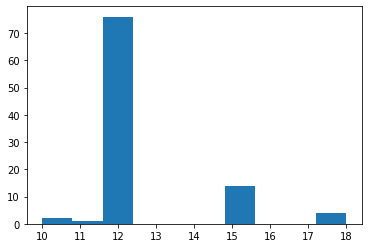

In [31]:
plt.hist(q2_3['Count'])
plt.show() 

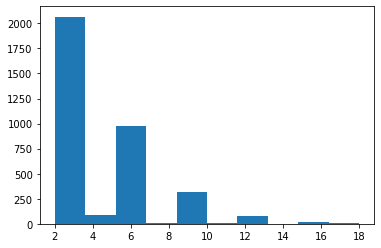

In [32]:
plt.hist(q2['Count'])
plt.show() 

#### Filter the products with more than 100 ratings in a certain city.

In [33]:
q3 = data[data['Review_Rating'] > 0].groupby(['Product_Name', 'Delivery_Zip_Code'])['Review_Rating'].count().reset_index(name='Count')

q3_2 = q3[q3['Count'] >= 10]

q3_3 = q3_2.sort_values('Count', ascending=False)

In [34]:
q3_3

,Product_Name,Delivery_Zip_Code,Count
104,Fitbit large,75215,272
166,Fitbit small,75215,269
528,Sony,75215,226
347,Logitech,75215,140
589,VR7,75215,137
...,...,...,...
473,Samsung s10,75379,10
256,JBL,30386,10
284,JBL,75210,10
287,JBL,75231,10


#### Filter the customers that have rated more than 10 products in a certain zip-code.

In [35]:
q4 = data[data['Review_Rating'] > 0].groupby(['CustomerID', 'Delivery_Zip_Code'])['Review_Rating'].count().reset_index(name='Count')

q4_2 = q4[q4['Count'] >= 10]

q4_3 = q4_2.sort_values('Count', ascending=False)

In [36]:
# We don't have any customers that have reviewed more than 10 products delievered to the same zip-code. Our max amount of reviewers per 
# customer per delievery zip code is 5.
q4_3

,CustomerID,Delivery_Zip_Code,Count


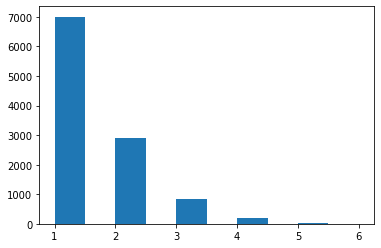

In [37]:
plt.hist(q4['Count'])
plt.show() 

#### Exclude products that are in the top 5 highest product returns from the dataset used to build the recommender system.

In [45]:
q5 = data[data['Order_Returned'] == 1].groupby(['Product_Name'])['OrderID'].count().reset_index(name='Count')

q5_2 = q5.sort_values('Count', ascending=False)

q5_3 = q5_2.iloc[5:, :]

In [46]:
# We only have 4 products that have been returned in the data set provided.
q5_3

,Product_Name,Count


In [47]:
q5_2

,Product_Name,Count
0,Fitbit small,2904
1,Harman Kardon,1445
2,JBL,910
3,Redmi,910
4,Samsung s10,910


## Data Preparation - SVD

In [5]:
df = pd.DataFrame()
df['user'] = data['CustomerID'].astype(str)
df['item'] = data['Product_Name'].astype(str)
df['rating'] = data['Review_Rating'].astype(int)
df = df.dropna()
df.head()

,user,item,rating
0,566-26-0321,Fitbit small,3
1,274-18-0017,Fitbit small,3
2,455-28-7950,Fitbit small,3
3,254-72-5938,Fitbit large,5
4,563-47-8401,Fitbit large,5


In [6]:
df.to_csv('transaction_train.csv', index=False)

with open("transaction_train.csv", "r") as f:
    reader = csv.DictReader(f, delimiter=',')
    with open("transaction_test.csv", "w",newline='') as f_out:
        writer = csv.DictWriter(f_out, fieldnames=reader.fieldnames, delimiter=",")
        for row in reader:
            writer.writerow(row)

## Data Preparation - Neural Net

In [7]:
df_tf = df.copy()

In [8]:
# Vectorization
ord_enc = OrdinalEncoder()
df_tf["item_encoded"] = ord_enc.fit_transform(df_tf[["item"]]).astype(int)
df_tf["item_encoded"] = df_tf["item_encoded"].apply(lambda x:(x+1))
df_tf["item_encoded"] = df_tf["item_encoded"]/max(df_tf["item_encoded"])

df_tf['user'] = df_tf['user'].replace('-', '', regex=True).astype(int)
df_tf['user_encoded'] = df_tf['user']/max(df_tf['user'])

df_tf['rating_encoded'] = df_tf['rating']/max(df_tf['rating'])

df_tf_input = df_tf[['user_encoded', 'item_encoded', 'rating_encoded']]
df_tf_input.head()

,user_encoded,item_encoded,rating_encoded
0,0.629502,0.3,0.6
1,0.304801,0.3,0.6
2,0.506136,0.3,0.6
3,0.283174,0.2,1.0
4,0.626409,0.2,1.0


In [9]:
X_train, X_test, y_train, y_test = train_test_split(df_tf_input.iloc[:, 0:2], df_tf_input.iloc[:, 2], test_size=0.3, random_state=123)

## Model 1 - Surprise Package - SVD Model - CPU


#### Data

In [54]:
svd_data = Dataset.load_from_file('transaction_test.csv', reader=Reader(line_format='user item rating', sep=','))
svd_trainset = svd_data.build_full_trainset()

#### GridSearch

In [8]:
svd_param_grid = {'n_epochs': [5, 10, 20], 'lr_all': [0, 0.002, 0.007, 0.013, .02], 'reg_all': [0.0, 0.2, 0.4, 0.6, 0.8, 0.1]}

svd_gs = GridSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=5)

In [9]:
%%time
svd_gs.fit(svd_data)

CPU times: user 3min 47s, sys: 1.13 s, total: 3min 48s
Wall time: 3min 50s


In [12]:
# best RMSE score
print(svd_gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(svd_gs.best_params['rmse'])

0.1938932499209973
{'n_epochs': 20, 'lr_all': 0.002, 'reg_all': 0.0}


#### Model

In [55]:
svd_algorithm = SVD(n_epochs=20, lr_all=0.002, reg_all=0.0)


In [56]:
svd_algorithm.fit(svd_trainset)

In [57]:
svd_testset = svd_trainset.build_anti_testset()


In [58]:
svd_predictions = svd_algorithm.test(svd_testset)

In [59]:
top_n = get_top_n(svd_predictions, n=3)

In [60]:
# Print the tope 3 recommended items for 10 users
count = 0
for uid, user_ratings in top_n.items():
  print(uid, [iid for (iid, _) in user_ratings])
  count += 1
  if count == 9:
    break

566-26-0321 ['VR7', 'Redmi', 'Harman Kardon']
274-18-0017 ['VR7', 'Harman Kardon', 'Redmi']
455-28-7950 ['Logitech', 'Fitbit large', 'VR7']
254-72-5938 ['Logitech', 'Sony', 'Redmi']
563-47-8401 ['VR7', 'Sony', 'Redmi']
848-43-9454 ['Fitbit large', 'VR7', 'Sony']
056-77-2913 ['VR7', 'Redmi', 'Fitbit small']
404-86-6657 ['VR7', 'Sony', 'Samsung s10']
653-90-2575 ['Logitech', 'VR7', 'Sony']


In [61]:
cross_validate(svd_algorithm, svd_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.1936  0.1963  0.1910  0.1980  0.1958  0.1949  0.0024  
MAE (testset)     0.0992  0.1003  0.0964  0.1019  0.0989  0.0993  0.0018  
Fit time          0.83    0.82    0.83    0.82    0.83    0.83    0.01    
Test time         0.03    0.02    0.02    0.03    0.02    0.03    0.00    


{'fit_time': (0.8326597213745117,
  0.817854642868042,
  0.8321106433868408,
  0.821770191192627,
  0.8330321311950684),
 'test_mae': array([0.09916365, 0.10032396, 0.09635686, 0.10193849, 0.09893152]),
 'test_rmse': array([0.1936319 , 0.19626227, 0.1909508 , 0.1980058 , 0.19576445]),
 'test_time': (0.025533676147460938,
  0.023517131805419922,
  0.0230410099029541,
  0.03072953224182129,
  0.023135662078857422)}

## Model 2 - Surprise Package - SVD Model - GPU

#### Data

In [10]:
svd_data = Dataset.load_from_file('transaction_test.csv', reader=Reader(line_format='user item rating', sep=','))
svd_trainset = svd_data.build_full_trainset()

#### GridSearch

In [29]:
svd_param_grid = {'n_epochs': [5, 10, 20], 'lr_all': [0, 0.002, 0.007, 0.013, .02], 'reg_all': [0.0, 0.2, 0.4, 0.6, 0.8, 0.1]}

svd_gs = GridSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=5)

In [30]:
%%time
svd_gs.fit(svd_data)

CPU times: user 3min 3s, sys: 1.78 s, total: 3min 5s
Wall time: 3min 5s


In [31]:
# best RMSE score
print(svd_gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(svd_gs.best_params['rmse'])

0.1943200768404633
{'n_epochs': 5, 'lr_all': 0.013, 'reg_all': 0.0}


#### Model

In [11]:
svd_algorithm_gpu = SVD(n_epochs=5, lr_all=0.013, reg_all=0.0)


In [12]:
svd_algorithm_gpu.fit(svd_trainset)


In [13]:
svd_testset_gpu = svd_trainset.build_anti_testset()


In [14]:
svd_predictions_gpu = svd_algorithm_gpu.test(svd_testset_gpu)


In [15]:
top_n = get_top_n(svd_predictions_gpu, n=3)

In [16]:
# Print the tope 3 recommended items for 10 users
count = 0
for uid, user_ratings in top_n.items():
  print(uid, [iid for (iid, _) in user_ratings])
  count += 1
  if count == 9:
    break

566-26-0321 ['VR7', 'Harman Kardon', 'Redmi']
274-18-0017 ['VR7', 'Harman Kardon', 'Redmi']
455-28-7950 ['VR7', 'Logitech', 'Fitbit large']
254-72-5938 ['Logitech', 'Sony', 'Redmi']
563-47-8401 ['VR7', 'Sony', 'Redmi']
848-43-9454 ['Fitbit large', 'VR7', 'Sony']
056-77-2913 ['VR7', 'Redmi', 'Fitbit small']
404-86-6657 ['VR7', 'Sony', 'Samsung s10']
653-90-2575 ['VR7', 'Logitech', 'Sony']


In [17]:
cross_validate(svd_algorithm_gpu, svd_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.1931  0.1964  0.1959  0.1981  0.1916  0.1950  0.0023  
MAE (testset)     0.0930  0.0960  0.0943  0.0944  0.0919  0.0939  0.0014  
Fit time          0.17    0.18    0.18    0.17    0.17    0.17    0.01    
Test time         0.02    0.02    0.02    0.02    0.02    0.02    0.00    


{'fit_time': (0.16914963722229004,
  0.1773076057434082,
  0.18134093284606934,
  0.1683192253112793,
  0.16517114639282227),
 'test_mae': array([0.09297025, 0.09598787, 0.09430922, 0.0943793 , 0.09185922]),
 'test_rmse': array([0.1931089 , 0.19635988, 0.19588888, 0.19811547, 0.19164177]),
 'test_time': (0.018233776092529297,
  0.018353939056396484,
  0.019902467727661133,
  0.01842474937438965,
  0.021240711212158203)}

## Model 3 - Tensorflow - LSTM Model - CPU

#### Model

In [62]:
model_3 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(2, )),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1)
])

In [63]:
model_3.compile(
    optimizer='adam',
    loss='mean_squared_error')

In [64]:
# Train Model
%%time

history_model_3 = model_3.fit(X_train, y_train, epochs=100,
                              validation_data=(X_test, y_test))

Epoch 1/100
359/359 [==============================] - 2s 5ms/step - loss: 0.0631 - val_loss: 0.0384
Epoch 2/100
359/359 [==============================] - 1s 3ms/step - loss: 0.0349 - val_loss: 0.0342
Epoch 3/100
359/359 [==============================] - 1s 4ms/step - loss: 0.0330 - val_loss: 0.0317
Epoch 4/100
359/359 [==============================] - 1s 4ms/step - loss: 0.0289 - val_loss: 0.0225
Epoch 5/100
359/359 [==============================] - 1s 4ms/step - loss: 0.0129 - val_loss: 0.0055
Epoch 6/100
359/359 [==============================] - 1s 3ms/step - loss: 0.0052 - val_loss: 0.0079
Epoch 7/100
359/359 [==============================] - 1s 4ms/step - loss: 0.0040 - val_loss: 0.0025
Epoch 8/100
359/359 [==============================] - 1s 3ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 9/100
359/359 [==============================] - 1s 3ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 10/100
359/359 [==============================] - 1s 3ms/step - loss: 0.0018 - val_lo

Text(0, 0.5, 'Training Error')

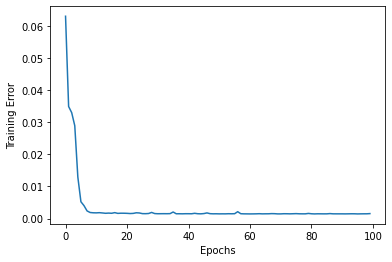

In [65]:
plt.plot(history_model_3.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")

In [66]:
# Creating dataset for making recommendations for the first user in our list, user 566260321
id_user = df_tf[df_tf['user'] == 566260321]
user = id_user[['user_encoded', 'item_encoded']]

predictions = model_3.predict(user)
predictions = np.array([a[0] for a in predictions])
predictions = [round(i, 1) for i in predictions]
items = pd.DataFrame(predictions, columns=['item_encoded']).merge(df_tf, how='left', on='item_encoded')
items['item'].drop_duplicates().dropna()

1    VR7
Name: item, dtype: object

## Model 4 - Tensorflow - Neural Network Model - GPU

#### Model

In [18]:
model_4 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(2, )),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1)
])

In [19]:
model_4.compile(
    optimizer='adam',
    loss='mean_squared_error')

In [20]:
# Train Model
%%time

history_model_4 = model_4.fit(X_train, y_train, epochs=100,
                              validation_data=(X_test, y_test))

Epoch 1/100
359/359 [==============================] - 4s 4ms/step - loss: 0.0673 - val_loss: 0.0489
Epoch 2/100
359/359 [==============================] - 1s 3ms/step - loss: 0.0375 - val_loss: 0.0346
Epoch 3/100
359/359 [==============================] - 1s 3ms/step - loss: 0.0340 - val_loss: 0.0342
Epoch 4/100
359/359 [==============================] - 1s 3ms/step - loss: 0.0334 - val_loss: 0.0330
Epoch 5/100
359/359 [==============================] - 1s 3ms/step - loss: 0.0325 - val_loss: 0.0335
Epoch 6/100
359/359 [==============================] - 1s 3ms/step - loss: 0.0299 - val_loss: 0.0278
Epoch 7/100
359/359 [==============================] - 1s 3ms/step - loss: 0.0227 - val_loss: 0.0243
Epoch 8/100
359/359 [==============================] - 1s 3ms/step - loss: 0.0102 - val_loss: 0.0052
Epoch 9/100
359/359 [==============================] - 1s 3ms/step - loss: 0.0062 - val_loss: 0.0052
Epoch 10/100
359/359 [==============================] - 1s 3ms/step - loss: 0.0059 - val_lo

Text(0, 0.5, 'Training Error')

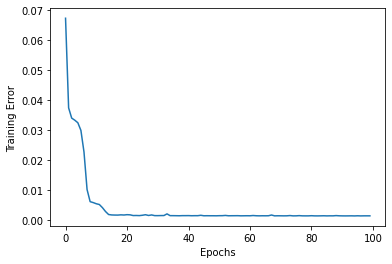

In [21]:
plt.plot(history_model_4.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")

In [22]:
# Creating dataset for making recommendations for the first user in our list, user 566260321
id_user = df_tf[df_tf['user'] == 566260321]
user = id_user[['user_encoded', 'item_encoded']]

predictions = model_4.predict(user)
predictions = np.array([a[0] for a in predictions])
predictions = [round(i, 1) for i in predictions]
items = pd.DataFrame(predictions, columns=['item_encoded']).merge(df_tf, how='left', on='item_encoded')
items['item'].drop_duplicates().dropna()

1    VR7
Name: item, dtype: object

## Summary

I use the SurPrise package and utilize the SVD algorithm on both a CPU and GPU. I use the GridSearchCV to get a sense of the "training" time in order to compare it with the training step utilized in the neural network algorithm. The "training" time for the CPU (3:50) was 47 seconds longer than for the GPU. Both had almost identifical RMSE of .2. Thus, between the two, I would use the SVD algorithm on a GPU.

For the neural network, the GPU was only 10 seconds faster (2:26) than the CPU. Both had similar RMSE of .0015. Depending on the cost consequences of using a GPU, a CPU could do the job.

Between the neural network and the SVD algorithms, the prefered method would be the neural network on a GPU. It is half a minute faster than the SVD and performs roughly 10 times better in terms of RMSE.